# Predict Yelp Ratings!

## 1. Introduction

Yelp data contains customers' reviews reflecting thier experience at a restaurant, like how they feel about foods, service or environment, and some other basic information of a certain restaurant, like location and categories. In this project, our group try to come up with a simple, robust, accurate as well as imterpretable method to estimate yelp ratings. 

**Thesis Statement**: Regularized logistic regression model is a fast and accurate classifier. To predict Yelp ratings based on 1.5 million train data, a L2-regularized logistic classfier spends less than **3** minutes on training and yields **$\text{rmse}=0.63$**.

## 2. Data pre-processing

### 2.1 Cleanning texts

- Step 1: Only keep words and several kinds of special punctuations from the raw data.
- Step 2: Remove stop words like "the, a, this..." and put all remaining words in a huge dictionary. Then remove those words with frequency less than 250 and get a dictionary with only 16k words.
- Step 3: Generate new words by combining "not" with the first adjective and verb appear behind it in current sentence. 

In [21]:
%run "code/data_clean_example.py"

Before:   Long time to get drinks ... Would not recommend.
After:    long time drinks notrecommend 


### 2.2 Special punctuations and category variable

We count how many times the special punctuations like ".. !! ?? :) :(" appear in a text and save the numbers as a sparse matrix. After generating a sparse matrix from words, we combine them together.

From star histograms of different categories, we believe that categories have effects on ratings. So we generate a sparse matrix for categories, and again combine it to our original sparse matrix.

## 3 Regularized Logistic Regreesion as a classifier

**Motivation:** For multi-class classfication problem, logistic regression as a classifier has advantages in speed and simple structure. Therefore, this is where we start.

### 3.1 TFIDF: Term Frequency–Inverse Document Frequency

Before fitting a logistic regression model, we need to construct our model matrix. Instead of using the raw frequencies of occurrence of a word in a text, we use TFIDF which is a numerical statistic that is intended to reflect how important a word is to a text (or say a sentence). The goal of using TFIDF is to scale down the impact of word with high frequency in the corpus. Let $w$, $t$ represent a word and a text,
$$\text{TF}(w,t) = \cfrac{\# w\ \text{in}\ t}{\text{#words in}\ t}, \quad \text{IDF}(w,t) = \log\cfrac{\text{#words in}\ t}{\text{#texts that contain}\ w}, \quad \text{TFIDF} = \text{TF} \times \text{IDF}$$

A constant 1 is added to the denominator and numerator to prevent zero divisions. After calculating the TFIDF for a text, the vector will be normalized . An example is shown below, suppose the corpus is composed of "This is not good", "This is delicious", and "Good".

\begin{equation}
\begin{pmatrix} 
1 & 1 & 1 & 1 & 0 \\
1 & 1 & 0 & 0 & 1 \\
0 & 0 & 0 & 1 & 0
\end{pmatrix} \Longrightarrow 
\begin{pmatrix} 
0.46 & 0.46 & 0.60 & 0.46 & 0 \\
0.52 & 0.52 & 0 & 0 & 0.68 \\
0 & 0 & 0 & 1 & 0
\end{pmatrix}
\end{equation}

The columns represent 'this''is''not''good''delicious' in proper order. We can see that 'not','delicious' and 'good' have the largest TFIDF within each text. **Basically, higher TFIDF means higher importance**.

### 3.2 Model fitting

First, we use cleaned data to build a large sparse matrix whose columns represent words  values are TFIDF. Then we build another sparse matrix whose columns represent categories and values are TFIDF. We combine them and get a sparse matrix with dimenson $1546379\times 17154$. This is the model matrix we will use in the following regularized logistic model. 

Let $p_i$ denote the probability of an $i$ stars rating, $m$ denote the number of texts, $n$ denote the number of unique words:

$$\text{P}(Y_i=k) = \cfrac{\exp({\mathbf{X}_i\beta_k})}{1+\sum_{k=1}^4\exp({\mathbf{X}_i\beta_k})}, \ k=1,2,3,4, \quad \text{P}(Y_i=5) = \cfrac{1}{1+\sum_{k=1}^4\exp({\mathbf{X}_i\beta_k})}$$

$$\text{Cost function}:\quad J(\beta) = -\cfrac{1}{m}\Big[\sum_{i=1}^{m}\sum_{j=1}^{5}\mathbf{1}_{\{Y_i=j\}}\log\text{P}(Y_i=j)\Big] + \cfrac{\lambda}{2}\sum_{k=1}^{5}\sum_{j=1}^{n}\beta_{kj}^2$$

A L-2 regularization term was added into the cost function to avoid over-fitting. Defazio, A. et al. (2014) proposed a fast incremental gradient method called SAGA to solve this optimization problem. In our model, $m=1546379$ and $n=17154$. But it only costs 3 minutes to train the model.

Before fitting a model, we need to tune the $\lambda$:

**1/$\lambda$**|1|1.5|2|2.2|2.5|3
:-----:|:-----:|:-----:|:-----:
**MSE on validation set**|0.4300|0.4271|0.4262|0.4261|0.4262|0.4266

In [1]:
%run "./code/logit-saga.py"

Time spent on training model: 0:02:49.709520


### 3.3 Diagnostic and interpretation

Our diagnosis is mainly based on root mean square error. The regularized logistic classifier we are using yields $\text{rMSE}= 0.63$.

Based on the coefficients in the model, we select 3 words with largest coefficient for 1-star and another 3 words for 5-star rating. We regard them as the top 3 negative/positive words.

| rank |  positive |  coef |  negative |  coef |
|:----:|:---------:|:-----:|:---------:|:-----:|
|   1  | delicious | 11.86 |   worst   | 10.88 |
|   2  |  amazing  | 11.27 | poisoning |  9.16 |
|   3  |   great   |  9.57 |  horrible |  9.04 |

Let $\text{odd}_k = \frac{\text{P}(\mathbf{Y}_i = k)}{1-\text{P}(\mathbf{Y}_i = k)}$. The coefficients of 'delicious', which is 11.86, means that if the TFIDF of 'delicious' increases by 0.1 and holding other variables constant, $\text{odd}_5$ will be multiplied by $\exp(1.186) = 3.27$. 

## 4 Neural Network

**Motivation:** Neural network is a very powerful tool in natural language processing. It has an advantage of high accuracy, but costs a lot of time to train data. To reach a higher accuracy, we try this method, too.

### 4.1 Word embedding

To train a neural network, we also need to map words or phrases to vectors of real numbers with fixed dimension. And that is known as word embedding. A common way to map words is training a shallow neural network. By word embedding, we can find most similar word of a given word, and which word does not match in a sentence. Here are some examples: 
- **amazing** is most similar to awesome
- **waitress** = waiter + woman - man
- **hotdog** doesn't match in "He is a very gentle hotdog".

### 4.2 FastText

Once we have those vectors that represent words, we can train a neural network to do supervised classification. FastText is an open-source library for text classification and representation provided by Facebook research. 
Different epoch number gives different rMSE:

**epoch**|25|50|100|200
:-----:|:-----:|:-----:|:-----:
**rMse**|0.74|0.70|0.65|0.65
**Training time**|5 min|15 min|$\sim$ 60 min|> 2 h

Dimension of word vector and learning rate is fixed to be 100 and 1.0. N-grams feature is applied and n is set to 3. When the number epoch is larger than 100, the rMSE doesn't change much.

From the result we can see that although the training time is much longer than the logistic model, the rMSE doesn't become smaller. This is due to the simple structure of neural network which fastText based on. Adding a long short term memory layer will greatly improve the result (but also spent much more time on training). 

## 5. Conclusion

We compared ordinary Lasso regression, regularized logistic regression and fastText based on rMSE and training time:

|      |  Lasso  | Regularized logistic | FastText |
|:----:|:-------:|:---------:|:--------:|
| rMSE | 0.8301 |   **0.6315**  |  0.6532  |
| Time |  60 min |   **3 min**   |  60 min |

Obviously regularized logistic regression classifier beats the other two methods. 

Here are two word cloud plots. The left(right) plot shows the top 100 positive(negative) words, which are sorted by the coefficient of 5-star(1-star) category (descending).

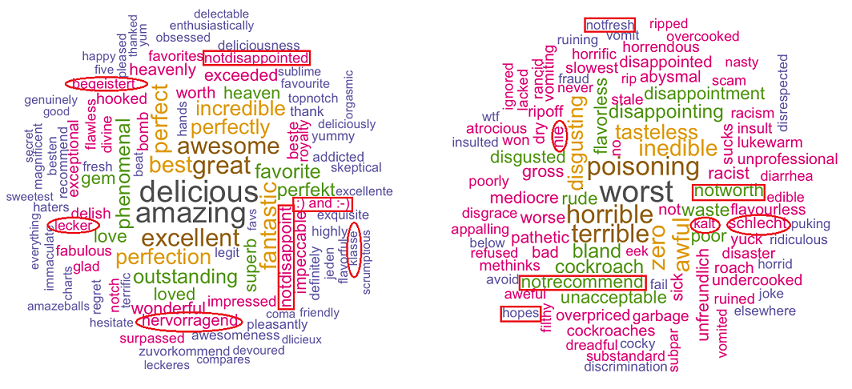

In [7]:
from IPython.display import Image
Image(filename="./image/wordcloud.png")

**Some interesting findings**
- **:) & :-)** are positive, as expected.
- 'hervorragend' means 'good' in German. 
- 'hopes' is a negative word! We read some reviews that include 'hope' and find that 'hope' typically appear with 'went there with hopes but...'.

**Strengths**
- Our model is **very fast** using less than **3** minutes, compared to other methods like neural work which costs many hours.
- Our model is **easy** to understand and interpret. 

**Weakness**
- LSTM outperforms our model in term of accuracy. We ranked 7th in the Kaggle competition.
- Multicollinearity exists, which might influence the coefficients (can even change signs).

## Reference

[1] Scikit-learn. Retrieved March 13, 2018, from http://scikit-learn.org/stable/index.html

[2] Facebookresearch/fastText. Retrieved March 13, 2018, from https://github.com/facebookresearch/fastText


## Contributions
* **Shiwei Cao**: Summary writing
* **Jiyun Chen**: Coding
* **Jing Guo**: Slides, summary writing